In [1]:
#!g1.1
%pip install pytorch-lightning
%pip install datasets
%pip install torchlibrosa

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 56 kB 908 kB/s            
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.4.0
    Uninstalling huggingface-hub-0.4.0:
      Successfully uninstalled huggingface-hub-0.4.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.17.0 requires huggingface-hub<1.0,>=0.1.0, but you have huggingface-hub 0.0.19 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --u

In [2]:
#!g1.1
%pip install --upgrade transformers

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 67 kB 761 kB/s             
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.0.19
    Uninstalling huggingface-hub-0.0.19:
      Successfully uninstalled huggingface-hub-0.0.19
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 1.5.0 requires huggingface-hub<0.1.0, but you have huggingface-hub 0.4.0 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [3]:
#!g1.1
import os
import pandas as pd
import numpy as np

import librosa
import wave

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.functional as FA
import torchaudio
import torchaudio.transforms as TA
import torchlibrosa as TL
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

from IPython.display import display, Audio

# 1. Анализ и разбиение данных 

In [4]:
#!g1.1

PATH_DATASET_DIR = "data/common_voice_ru"
# PATH_DATASET_DIR = "/content/drive/MyDrive/Alice-biometry/cache_folder"

MIN_RECORDS = 20

In [5]:
#!g1.1
from datasets import load_dataset

common_voice_dataset = load_dataset('common_voice', 'ru', cache_dir=PATH_DATASET_DIR)

Reusing dataset common_voice (data/common_voice_ru/common_voice/ru/6.1.0/0041e06ab061b91d0a23234a2221e87970a19cf3a81b20901474cffffeb7869f)


In [6]:
#!g1.1

raw_df_train = pd.DataFrame(common_voice_dataset["train"])
raw_df_test = pd.DataFrame(common_voice_dataset["test"])
raw_df_val = pd.DataFrame(common_voice_dataset["validation"])

raw_df = pd.concat([raw_df_train, raw_df_val, raw_df_test]) \
    .groupby("client_id") \
    .filter(lambda x: len(x) >= MIN_RECORDS) \
    .reset_index(drop=True)

In [8]:
#!g1.1

def train_test_split(raw_df, split_treshold=50):
    train_df = raw_df.groupby("client_id").filter(lambda x: len(x) >= split_treshold)
    test_df = raw_df.groupby("client_id").filter(lambda x: len(x) < split_treshold)

    return train_df, test_df

In [9]:
#!g1.1
train_df, test_df = train_test_split(raw_df)

In [10]:
#!g1.1
train_df.to_csv(os.path.join(PATH_DATASET_DIR, "train_biometry.tsv"), sep='\t')
test_df.to_csv(os.path.join(PATH_DATASET_DIR, "test_biometry.tsv"), sep='\t')

#  2. Создание датасета и моделей

In [11]:
#!g1.1
class CommonVoiceBiometryDataset(Dataset):
    """
    Create a Dataset CommonVoice for biometry.
    """
    _ext_txt = ".txt"
    _ext_audio = ".mp3"
    _folder_audio = "clips"
    _eps = 10e-9
    
    def __init__(self, 
                 root, 
                 tsv,
                 transforms = None,
                 specimen_number = 4,
                 people_treshold = 100, 
                 count_samples = 8,
                 resample_rate = 32000,
                 waveform_treshold = 200000):
        super().__init__()
        
        assert count_samples <= people_treshold
        
        self._path = os.fspath(root)
        self._tsv = os.path.join(self._path, tsv)
        self._transforms = transforms
        self._specimen_number = specimen_number
        self._count_samples = count_samples
            
        self._df = pd.read_csv(self._tsv, sep='\t', low_memory=False) \
            .groupby("client_id") \
            .filter(lambda x: len(x) >= people_treshold) \
            .reset_index(drop=True)
        
        self._clients_id = self._df["client_id"].unique()
        self._resample_rate = resample_rate
        self._waveform_treshold = waveform_treshold
        
    def __getitem__(self, n):
        current_client_id = self._clients_id[n]
        client_df = self._df[self._df["client_id"] == current_client_id] \
            .sample(n=self._count_samples)
        
        specimen_X = []
        X = []

        for idx, fileid in enumerate(client_df["path"]):
            filename = fileid
            # filename = os.path.join(self._path, self._folder_audio, fileid)
        
            if not filename.endswith(self._ext_audio):
                filename += self._ext_audio
            
            waveform, sample_rate = torchaudio.load(filename, normalize=True)
            
            resampled_waveform = FA.resample(waveform, 
                                             sample_rate, 
                                             self._resample_rate)
            
            if resampled_waveform.shape[1] >= self._waveform_treshold:
                resampled_waveform = resampled_waveform[:, :self._waveform_treshold]
            else:
                resampled_waveform = F.pad(
                    resampled_waveform, 
                    (0, self._waveform_treshold - resampled_waveform.shape[1], 0, 0),
                    value=resampled_waveform.min()
                )          
            
            if self._transforms is not None:
                resampled_waveform = self._transforms(resampled_waveform)
            
            if idx < self._specimen_number:
                specimen_X.append(resampled_waveform) 
            else:
                X.append(resampled_waveform)

        return torch.cat(X, dim=0), torch.cat(specimen_X, dim=0), current_client_id
    
    def __len__(self):
        return len(self._clients_id)

In [39]:
#!g1.1
class LSTMEncoder(nn.Module):
    def __init__(self, 
             input_size,
             hidden_size,
             proj_size,
             num_layers):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                proj_size=proj_size,
                num_layers=num_layers,
                batch_first=True
            )
        )
    
    
    def forward(self, x):
        return self.net(x.squeeze(dim=1))[0][:, -1]

In [13]:
#!g1.1
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2)
        )
    

    def forward(self, x):
        return self.conv_block(x)

In [14]:
#!g1.1
class ConvEncoder(nn.Module):
    def __init__(self,
                 in_time=626,
                 in_features=128,
                 in_channels=1,
                 embedding_size=256):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.LayerNorm([in_channels, in_time, in_features]),
            nn.LeakyReLU(inplace=True),
            ConvBlock(in_channels=in_channels, out_channels=64),
            nn.Dropout2d(p=0.2, inplace=True),
            ConvBlock(in_channels=64, out_channels=128),
            nn.Dropout2d(p=0.2, inplace=True),
            ConvBlock(in_channels=128, out_channels=256),
            nn.Dropout2d(p=0.2, inplace=True),
            ConvBlock(in_channels=256, out_channels=512),
            nn.Dropout2d(p=0.2, inplace=True),
            ConvBlock(in_channels=512, out_channels=1024),
            nn.Dropout2d(p=0.2, inplace=True),
            ConvBlock(in_channels=1024, out_channels=2048),
        )
        
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048 * (in_time // 64) * (in_features // 64), embedding_size)
        )
        
        
    def forward(self, x):        
        x = self.conv(x)
        
        return self.dense(x)

In [15]:
#!g1.1
class Discriminator(nn.Module):
    def __init__(self,
                 input_size=256,
                 d_size=200,
                 hidden_size=256,
                 negative_slope=0.2,
                 use_cos=True,
                 use_net=True):
        super().__init__()
        assert use_cos or use_net
        
        self.cos_disc = nn.CosineSimilarity(dim=1)
        self.d_size = d_size
        
        self.net_disc = nn.Sequential(
            nn.Linear(2 * input_size, hidden_size),
            nn.LeakyReLU(negative_slope),
            
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope),
            
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope),
            
            nn.Linear(hidden_size, 1)
        )
        
        self.use_cos = use_cos
        self.use_net = use_net
        self.score_combinator = nn.Linear(2, 1)
        
    def forward(self, X, specimen_X):
        if self.use_cos:
            cos_output = self.cos_disc(X[:, :self.d_size], specimen_X[:, :self.d_size]) \
                [..., None]
            
        if self.use_net:
            specimen_X_rep = specimen_X.repeat(X.shape[0], 1)

            net_output = self.net_disc(torch.cat([X, specimen_X_rep], dim=1))

        if self.use_cos and self.use_net:
            output = torch.cat([cos_output, net_output], dim=1)
            return self.score_combinator(output)
        elif self.use_cos:
            return cos_output
        elif self.use_net:
            return net_output

In [16]:
#!g1.1
from IPython.core.display import clear_output


def GE2E_XS_Loss(scoring_block):    
    scoring_block = scoring_block - scoring_block.max()
    exp_scoring_block = torch.exp(scoring_block)
    
    diag = torch.diagonal(scoring_block)
    exp_diag = torch.diagonal(exp_scoring_block)
    exp_block_sum = exp_scoring_block.sum()
    exp_diag_sum = exp_diag.sum()
    
    loss = -torch.sum(diag - torch.log(exp_diag + exp_block_sum - exp_diag_sum))

    return loss

def GE2G_Loss(score_matrix, eps = 1e-9):
    count_rec, n_speakers = score_matrix.shape
    n_blocks = count_rec // n_speakers
    
    loss = 0
    
    for idx in range(n_speakers):
        for jdx in range(n_blocks):
            speakers_res = score_matrix[idx * n_blocks + jdx]
            
            loss -= speakers_res[idx] - torch.log(torch.sum(torch.exp(speakers_res)) + eps)
    
    return loss

def get_predictions(score_matrix, threshold):
    return score_matrix >= threshold

def get_ground_truth(predictions):
    ground_truth = torch.zeros_like(predictions, dtype=bool)
    n_speakers = predictions.shape[1]
    samples_per_speaker = predictions.shape[0] // n_speakers
    
    for i in range(n_speakers):
        ground_truth[i * samples_per_speaker: (i + 1) * samples_per_speaker, i] = True
    
    return ground_truth

def get_far(ground_truth, predictions):
    """
    FAR: FP / (FP + TN)
    """
    fp = float(torch.sum(predictions & (~ground_truth)))
    tn = float(torch.sum((~predictions) & (~ground_truth)))
    far = fp / (fp + tn) if fp != 0 else 0
    return far

def get_frr(ground_truth, predictions):
    """
    FRR: FN / (FN + TP)
    """
    fn = float(torch.sum((~predictions) & ground_truth))
    tp = float(torch.sum(predictions & ground_truth))
    frr = fn / (fn + tp) if fn != 0 else 0
    return frr

def get_metrics(score_matrix, threshold):
    preds = get_predictions(score_matrix, threshold)
    ground_truth = get_ground_truth(preds)

    far = get_far(ground_truth, preds)
    frr = get_frr(ground_truth, preds)

    return far, frr

def get_eer(far, frr):
    maximum = np.maximum(far, frr)
    eer = np.min(maximum)
    eer_threshold_index = (np.argmin(maximum) + (len(maximum) - np.argmin(maximum))[::-1]) // 2
    return eer, eer_threshold_index

def smooth(array, window_size):
    return [np.mean(array[max(0, i - window_size): i + 1]) for i in range(len(array))]
    

class BiometryModel(pl.LightningModule):
    def __init__(self, encoder, discriminator):
        super().__init__()
        
        self._encoder = encoder
        self._discriminator = discriminator
        self._loss = GE2G_Loss
        self._specimen_d_vector = None

        self.train_loss_history = []
        self.val_loss_history = []

        # parameters for EER
        self.n_points = 501
        self.a = -25
        self.b = 25
        self.train_eer_history = []
        self.val_eer_history = []
        self.window_size = 5
        
        self.threshold = 0
        
        self.train_threshold_index_history = []
        self.last_train_outputs = None
    
    def set_specimen_d_vector(self, x):
        encod_sounds = self._encoder(x)
        self._specimen_d_vector = torch.mean(encod_sounds, dim=0, keepdims=True)
        
    def get_specimen_d_vector(self):
        return self._specimen_d_vector
    
    def forward(self, x):
        assert self._specimen_d_vector != None, "The voice sample vector is not set"
        
        encod_sounds = self._encoder(x)
        
        return self._discriminator(encod_sounds, self._specimen_d_vector)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def _step(self, batch, step_type):
        assert step_type in {"train", "val", "treshold"}

        X_batch, specimen_X_batch, _ = batch
        
        # loss calculation
        loss = 0
        score_blocks = []
        
        n_speakers, n_records_per_speaker, n_channels, n_times, n_features = X_batch.shape
        n_specimens = specimen_X_batch.shape[1]
        
        specimen_X = specimen_X_batch.view(n_speakers * n_specimens, n_channels, n_times, n_features)
        encod_specimen_X = self._encoder(specimen_X).view(n_speakers, n_specimens, -1)
        
        X = X_batch.view(n_speakers * n_records_per_speaker, n_channels, n_times, n_features)
        encod_X = self._encoder(X)
        
        list_speakers_dist = []
        
        for specimen_x in encod_specimen_X:            
            specimen_x = torch.mean(specimen_x, dim=0, keepdims=True)
            list_speakers_dist.append(self._discriminator(encod_X, specimen_x))
            
        speakers_dist = torch.cat(list_speakers_dist, dim=1)
        
        
        if step_type == "treshold":
            threshold_grid = np.linspace(self.a, self.b, num=self.n_points)

            metrics = [
                (threshold, *get_metrics(score_matrix=speakers_dist, threshold=threshold))
                for threshold in threshold_grid
            ]
            return {"treshold_metrics": metrics}
        else:
            loss = self._loss(speakers_dist)
            self.log(f"{step_type}_loss", loss)
            
            threshold_grid = np.linspace(self.a, self.b, num=self.n_points)

            metrics = [
                (threshold, *get_metrics(score_matrix=speakers_dist, threshold=threshold))
                for threshold in threshold_grid
            ]
            return {"loss": loss, "metrics": metrics}
            
        #loss = self._loss(speakers_dist)
        #self.log(f"{step_type}_loss", loss)

        # metrics calculation
        #threshold_grid = np.linspace(self.a, self.b, num=self.n_points)

        #metrics = [
        #    (threshold, *get_metrics(score_matrix=speakers_dist, threshold=threshold))
        #    for threshold in threshold_grid
        #]

        #return {"loss": loss, "metrics": metrics}
    
    def training_step(self, train_batch, batch_idx):
        return self._step(train_batch, step_type="train")
        
    def validation_step(self, val_batch, batch_idx):
        test_batch = [elem[:-2] for elem in val_batch]
        batch_treshold = [elem[-2:] for elem in val_batch]
        
        return {**self._step(test_batch, step_type="val"), **self._step(batch_treshold, step_type="treshold")}
    
    def _calculate_treshold(self, outputs):
        threshold_grid = np.array([item[0] for item in outputs[0]["treshold_metrics"]])

        far = np.array([0] * len(threshold_grid))
        frr = np.array([0] * len(threshold_grid))

        for output in outputs:
            for i, item in enumerate(output["treshold_metrics"]):
                far[i] += item[1]
                frr[i] += item[2]
        
        far = far / len(outputs)
        frr = frr / len(outputs)

        maximum = np.maximum(far, frr)
        cur_eer_threshold_index = (np.argmin(maximum) + len(maximum) - np.argmin(maximum[::-1])) // 2
        cur_threshold = threshold_grid[cur_eer_threshold_index]
        
        return cur_threshold, cur_eer_threshold_index
    
    def _estimate_metrics(self, outputs, eer_history, axs, end_type):
        threshold_grid = np.array([item[0] for item in outputs[0]["metrics"]])

        far = np.array([0] * len(threshold_grid))
        frr = np.array([0] * len(threshold_grid))

        for output in outputs:
            for i, item in enumerate(output["metrics"]):
                far[i] += item[1]
                frr[i] += item[2]
        
        far = far / len(outputs)
        frr = frr / len(outputs)

        maximum = np.maximum(far, frr)
        cur_eer = np.min(maximum)
        cur_eer_threshold_index = (np.argmin(maximum) + len(maximum) - np.argmin(maximum[::-1])) // 2
        cur_threshold = threshold_grid[cur_eer_threshold_index]

        eer = None
        eer_threshold_index = None
        threshold = None
        
        if self.train_threshold_index_history:
            eer_threshold_index = self.train_threshold_index_history[-1]
            eer = maximum[eer_threshold_index]
            threshold = threshold_grid[eer_threshold_index]
            axs[1].plot(cur_threshold, cur_eer, "o", label="best threshold", c="red")

        axs[1].plot(threshold_grid, far, label="FAR")
        axs[1].plot(threshold_grid, frr, label="FRR")

        if eer_threshold_index:
            eer_history.append(eer)
            threshold = threshold_grid[eer_threshold_index]
            axs[1].plot(threshold, eer, "o", label="threshold", c="green")
        
        axs[1].set_xlabel("threshold")
        axs[1].legend()
        axs[1].grid(True)

        axs[2].plot(range(len(eer_history)), eer_history, label="EER")
        axs[2].plot(
            range(len(eer_history)),
            smooth(eer_history, window_size=self.window_size),
            label=f"{self.window_size}-smooth EER",
            c="aqua"
        )
        axs[2].set_xlabel("epoch")
        axs[2].legend()
        axs[2].grid(True)

    def training_epoch_end(self, outputs):
        loss_values = [float(output['loss']) for output in outputs]
        avg_loss = np.mean(loss_values)
        self.train_loss_history.append(avg_loss)
        self.last_train_outputs = outputs
    
    def validation_epoch_end(self, outputs):
        avg_loss = np.mean([float(output['loss']) for output in outputs])
        self.val_loss_history.append(avg_loss)
        
        # train logs
        if self.last_train_outputs:
            _, cur_eer_threshold_index = self._calculate_treshold(outputs)
            self.train_threshold_index_history.append(cur_eer_threshold_index)
            
            clear_output()
            fig, axs = plt.subplots(1, 3, figsize=(18, 4))

            axs[0].plot(range(len(self.train_loss_history)), self.train_loss_history, label="loss")
            axs[0].plot(
                range(len(self.train_loss_history)),
                smooth(self.train_loss_history, window_size=self.window_size),
                label=f"{self.window_size}-smooth loss",
                c="aqua"
            )
            axs[0].set_xlabel("epoch")
            axs[0].legend()
            axs[0].grid(True)

            self._estimate_metrics(self.last_train_outputs, self.train_eer_history, axs, end_type="train")
            plt.show()

            print(f"Train loss: {self.train_loss_history[-1]:.3f}\t" \
                  f"Train EER: {self.train_eer_history[-1]:.3f}\t" \
                  f"Smoothed train EER: {smooth(self.train_eer_history, window_size=self.window_size)[-1]:.3f}")

        # val logs
        fig, axs = plt.subplots(1, 3, figsize=(18, 4))

        axs[0].plot(range(len(self.val_loss_history)), self.val_loss_history, label="loss")
        axs[0].plot(
            range(len(self.val_loss_history)),
            smooth(self.val_loss_history, window_size=self.window_size),
            label=f"{self.window_size}-smooth loss",
            c="aqua"
        )
        axs[0].set_xlabel("epoch")
        axs[0].legend()
        axs[0].grid(True)

        self._estimate_metrics(outputs, self.val_eer_history, axs, end_type="val")
        plt.show()

        if self.val_eer_history:
            print(f"Val loss: {self.val_loss_history[-1]:.3f}\t" \
                  f"Val EER: {self.val_eer_history[-1]:.3f}\t" \
                  f"Smoothed val EER: {smooth(self.val_eer_history, window_size=self.window_size)[-1]:.3f}")

# 3. Обучение и тестирование

In [17]:
#!g1.1
SAMPLE_RATE = 32000

transforms = nn.Sequential(
    TL.Spectrogram(
        n_fft=1024,
        hop_length=320,
    ), TL.LogmelFilterBank(
        sr=SAMPLE_RATE,
        n_mels=128, 
        n_fft=1024,
        fmin=20, 
        fmax=16000,
    )
)

train_ds = CommonVoiceBiometryDataset(
    PATH_DATASET_DIR, 
    "train_biometry.tsv",
    transforms=transforms,
    specimen_number = 4,
    people_treshold = 50,
    count_samples = 8,
    resample_rate = SAMPLE_RATE,
    waveform_treshold = 200000
)

test_ds = CommonVoiceBiometryDataset(
    PATH_DATASET_DIR, 
    "test_biometry.tsv",
    transforms=transforms,
    specimen_number = 4,
    people_treshold = 20,
    count_samples = 8,
    resample_rate = SAMPLE_RATE,
    waveform_treshold = 200000
)

print(len(train_ds), len(test_ds))

/kernel/lib/python3.8/site-packages/ml_kernel/ignored_keyboard_interrupt.py:16: UserWarning: Kernel cannot be interrupted during state load
  warnings.warn(self._warn_message)


129 117


In [18]:
#!g1.1
train_dl = DataLoader(train_ds, batch_size=5, shuffle=True, num_workers=8)
test_dl = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=8, drop_last=True)

In [19]:
#!g1.1
for X, specimen_X, _ in train_dl:
    print(X.shape, specimen_X.shape)
    break

torch.Size([5, 4, 1, 626, 128]) torch.Size([5, 4, 1, 626, 128])


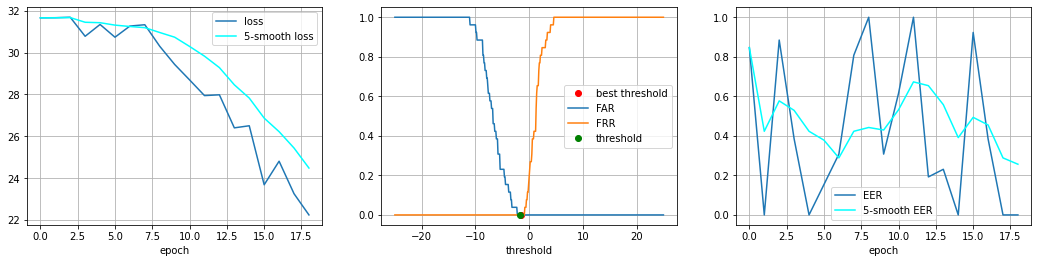

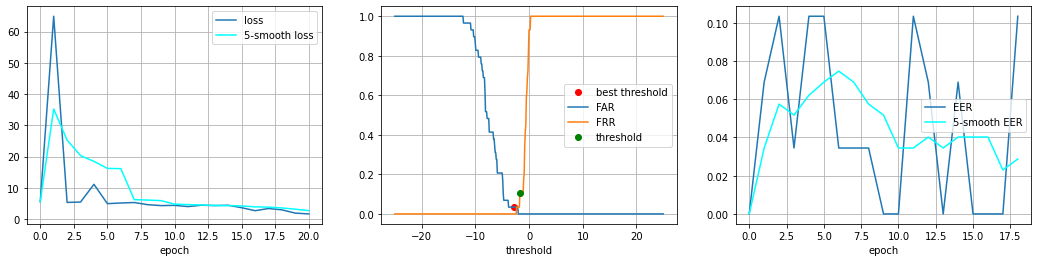

Train loss: 22.236	Train EER: 0.000	Smoothed train EER: 0.256
Val loss: 1.652	Val EER: 0.103	Smoothed val EER: 0.029


In [ ]:
#!g1.1
model = BiometryModel(
    encoder=ConvEncoder(
        in_time=626,
        in_features=128,
        embedding_size=256
    ),
    discriminator=Discriminator(
        input_size=256,
        d_size=200,
        hidden_size=256,
        negative_slope=0.2,
        use_cos=True,
        use_net=True
    )
)

trainer = pl.Trainer(max_epochs=20, gpus=int(torch.cuda.is_available()), log_every_n_steps=1)
trainer.fit(model, train_dl, test_dl)

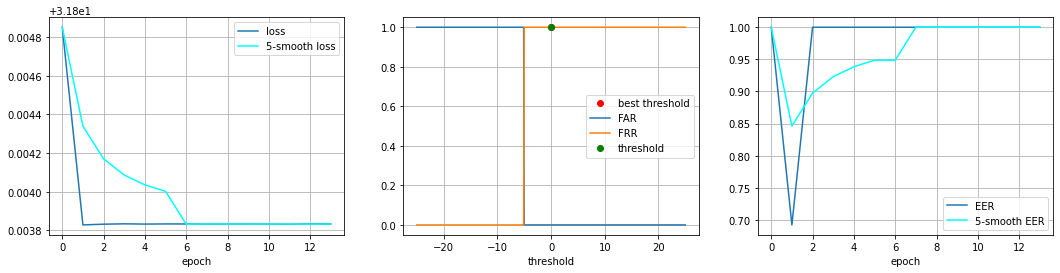

Train loss: 31.804	Train EER: 1.000	Smoothed train EER: 1.000


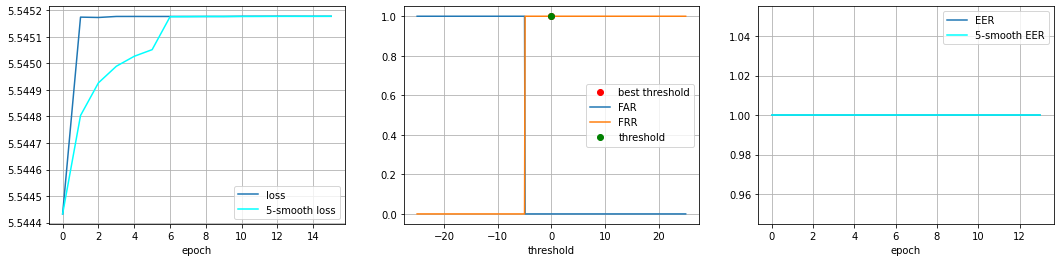

Val loss: 5.545	Val EER: 1.000	Smoothed val EER: 1.000


In [ ]:
#!g1.1
model = BiometryModel(
    encoder=LSTMEncoder(
        input_size=128,
        hidden_size=768,
        proj_size=256,
        num_layers=3
    ),
    discriminator=Discriminator(
        input_size=256,
        d_size=200,
        hidden_size=256,
        negative_slope=0.2,
        use_cos=True,
        use_net=True
    )
)


trainer = pl.Trainer(max_epochs=20, gpus=int(torch.cuda.is_available()), log_every_n_steps=1)
trainer.fit(model, train_dl, test_dl)